In [1]:
import os

import h5py
import nibabel as nib
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
plt.style.use("dark_background")

from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

import warnings
# Suppress specific OpenCV warnings about file reading
warnings.filterwarnings("ignore", message="global loadsave.cpp")
# Suppress all warnings
warnings.filterwarnings("ignore")
import logging
# Suppress specific OpenCV warnings about file reading
logging.getLogger('cv2').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message="findDecoder imread")

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize  # Assuming you use scikit-image for resizing



from keras.utils import Sequence
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2  

2024-06-23 20:11:14.963784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 20:11:14.964054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 20:11:15.156680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install timm einops ml_collections wget tensorboardX SimpleITK medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94507 sha256=777a02023d92175c91c4ca52b78cd9204cf640de6b82fad06885d2df7eba1dfc
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=c7d5c7d52d7677d71f610a4c3a1738da638598619ec169f98c545c0cdd40e60d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
  Created wheel for medpy: filename=MedPy-0.5.1-py3-none-any.whl size=224731 sha256=bfe30972caf62fe65d62ed2a1ad5c06

In [3]:
!pip install -U datasets trl accelerate peft bitsandbytes transformers trl huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.2
    Uninstalling huggingface-hub-0.23.2:
      Successfully uninstalled huggingface-hub-0.23.2
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.30.1
    Uninstalling accelerate-0.30.1:
      Successfully uninstalled accelerate-0.30.1
  Attempting uninstall: datasets
    Found existing installati

In [4]:
!git clone "https://huggingface.co/Unknown6197/BEFUnet_Brats2020"

Cloning into 'BEFUnet_Brats2020'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 84 (delta 16), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (84/84), 576.86 KiB | 5.55 MiB/s, done.
Filtering content: 100% (3/3), 270.02 MiB | 117.01 MiB/s, done.


# **Segmentation Model**

In [6]:
#cd /kaggle/working/BEFUnet_Brats2020
import sys
sys.path.insert(1,'/kaggle/working/BEFUnet_Brats2020')

In [7]:
from datasets import dataset_synapse

db_train = dataset_synapse.Synapse_dataset(base_dir="/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data",
                                           list_dir="/kaggle/working/BEFUnet_Brats2020/lists",
                                           split="train",
                                           transform=v2.Compose([
                                               dataset_synapse.RandomGenerator(output_size=[224,224])
                                           ]))

db_test = dataset_synapse.Synapse_dataset(base_dir="/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data",
                                           list_dir="/kaggle/working/BEFUnet_Brats2020/lists",
                                           split="test_vol",
                                           transform=v2.Compose([
                                               dataset_synapse.transform_test(output_size=[224,224])
                                           ]))

train_loader = DataLoader(db_train, batch_size=5, shuffle=True)
test_loader = DataLoader(db_test, batch_size=1, shuffle=False)

In [8]:
for sample in train_loader:
    print('Train image shape ' , sample['image'].shape , ', label shape ' , sample['label'].shape, ', Number of Training Batches' , len(db_train)//5)
    break
for sample in test_loader:
    print('test image shape ' , sample['image'].shape , ', label shape ' , sample['label'].shape, ', Number of test Batches' , len(db_test))
    break

Train image shape  torch.Size([5, 1, 224, 224]) , label shape  torch.Size([5, 224, 224]) , Number of Training Batches 10078
test image shape  torch.Size([1, 1, 224, 224]) , label shape  torch.Size([1, 224, 224]) , Number of test Batches 509


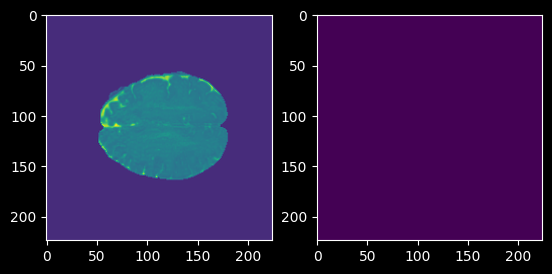

In [9]:
for sample in train_loader:
    img = sample["image"][:]
    mask = sample["label"][:]
    fig,axs = plt.subplots(1,2)
    axs[0].imshow(img[0].squeeze(0))
    axs[1].imshow(mask[0])
    break

# **Model**

In [10]:
from configs.BEFUnet_configs import get_BEFUnet_configs
from models.BEFUnet import BEFUnet

cfg = get_BEFUnet_configs()
model = BEFUnet(cfg,n_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

{'layer0': 'cd', 'layer1': 'ad', 'layer2': 'rd', 'layer3': 'cv', 'layer4': 'cd', 'layer5': 'ad', 'layer6': 'rd', 'layer7': 'cv', 'layer8': 'cd', 'layer9': 'ad', 'layer10': 'rd', 'layer11': 'cv', 'layer12': 'cd', 'layer13': 'ad', 'layer14': 'rd', 'layer15': 'cv'}
initialization done


BEFUnet(
  (All2Cross): All2Cross(
    (pyramid): PyramidFeatures(
      (swin_transformer): SwinTransformer(
        (pos_drop): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0): BasicLayer(
            dim=96, input_resolution=(56, 56), depth=2
            (blocks): ModuleList(
              (0): SwinTransformerBlock(
                dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
                (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (attn): WindowAttention(
                  dim=96, window_size=(7, 7), num_heads=3
                  (qkv): Linear(in_features=96, out_features=288, bias=True)
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linear(in_features=96, out_features=96, bias=True)
                  (proj_drop): Dropout(p=0.0, inplace=False)
                  (softmax): Softmax(dim=-1)
                )
                (drop_path): I

In [11]:
from utils import DiceLoss
epochs = 10
lr = 0.001
dice_loss = DiceLoss(3)
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr,weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [12]:
def train_model(model,train_loader,epochs,lr,device):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        print(f"epoch {epoch+1}",end=' ')
        for batch in tqdm(train_loader):
            image_batch, label_batch = batch['image'], batch['label']
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            B, C, H, W = image_batch.shape
            image_batch = image_batch.expand(B, 3, H, W)
            
            outputs = model(image_batch)
            
            loss_ce = ce_loss(outputs, label_batch[:].long())
            loss_dice = dice_loss(outputs, label_batch, softmax=True)
            loss = 0.4 * loss_ce + 0.6 * loss_dice
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  
            running_loss += loss.item()
            
        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
        torch.save(model.state_dict(), f'/kaggle/working/model_weights{epoch+1}.pth')
        print("Weights Saving done!")
        torch.save(scheduler.state_dict(), f'/kaggle/working/scheduler_epoch_{epoch+1}.pth')
        print("Scheduler Saved")

In [ ]:
train_model(model,train_loader,epochs,lr,device)

In [13]:
# Load the weights into a dictionary
weights_path = '/kaggle/working/BEFUnet_Brats2020/weights/model_weights_brats_9_Adam.pth'
weights_dict = torch.load(weights_path, map_location=torch.device(device))
# Load the weights into your model
model.load_state_dict(weights_dict)

<All keys matched successfully>

In [19]:
def calculate_miou(mask, seg_pred):
    
    mask = mask.detach().numpy()
    
    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)
    
    intersection = np.logical_and(mask, seg_pred)
    union = np.logical_or(mask, seg_pred)

    # Calculate IoU
    if np.sum(union) == 0:
        return 1 if np.sum(intersection) == 0 else 0
    else:
        # Calculate IoU
        iou = np.sum(intersection) / np.sum(union)
        return iou

def calculate_dice_loss(mask, seg_pred):
    mask = mask.detach().numpy()

    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)

    # Calculate Intersection
    intersection = np.sum(mask * seg_pred)

    # Calculate Dice loss
    dice_loss = 1 - ((2. * intersection + 1e-6) / (np.sum(mask) + np.sum(seg_pred) + 1e-6))

    return dice_loss


def calculate_precision(mask, seg_pred):
    mask = mask.detach().numpy()
    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)

    # Calculate True Positives (TP) and False Positives (FP)
    TP = np.sum((seg_pred == 1) & (mask == 1))
    FP = np.sum((seg_pred == 1) & (mask == 0))

    # Calculate Precision
    precision = TP / (TP + FP + 1e-6)

    return precision

def calculate_recall(mask, seg_pred):
    mask = mask.detach().numpy()
    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)

    # Calculate True Positives (TP) and False Negatives (FN)
    TP = np.sum((seg_pred == 1) & (mask == 1))
    FN = np.sum((seg_pred == 0) & (mask == 1))

    # Calculate Recall
    recall = TP / (TP + FN + 1e-6)

    return recall

def calculate_f1_score(mask, seg_pred):
    mask = mask.detach().numpy()
    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((seg_pred == 1) & (mask == 1))
    FP = np.sum((seg_pred == 1) & (mask == 0))
    FN = np.sum((seg_pred == 0) & (mask == 1))

    # Calculate Precision and Recall
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    return f1_score


Print 10 test samples


  0%|          | 0/509 [00:00<?, ?it/s]

Batch 1


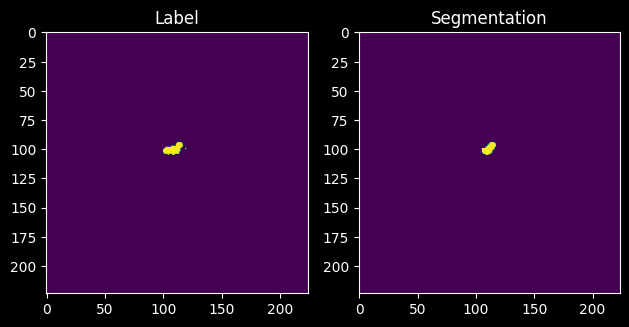

Batch 2


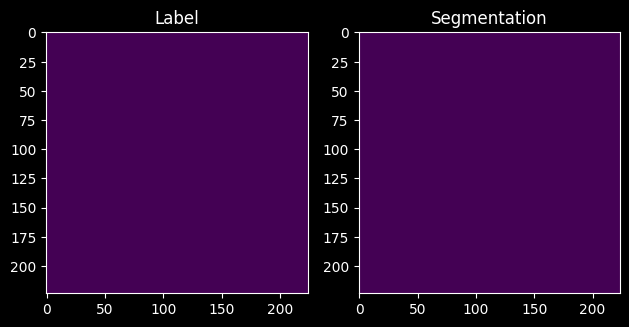

Batch 3


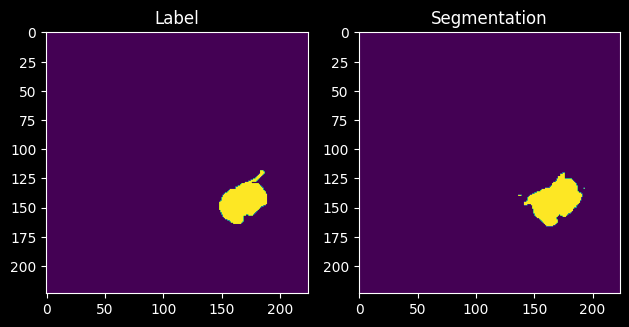

Batch 4


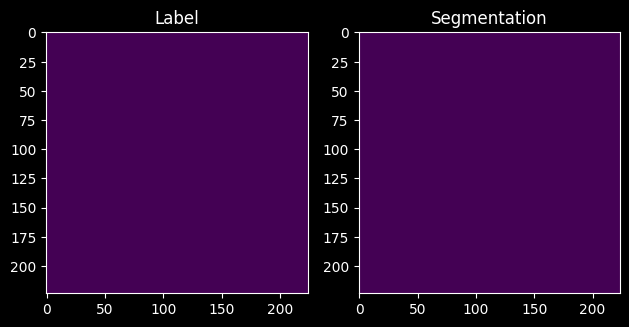

Batch 5


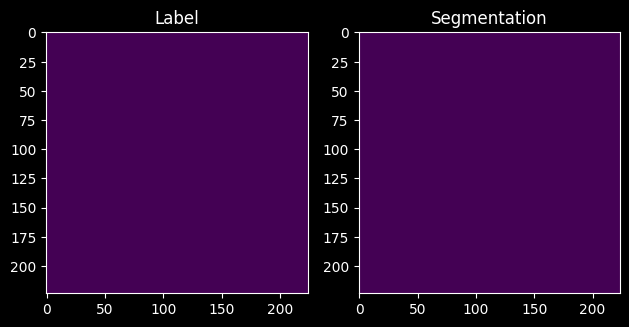

Batch 6


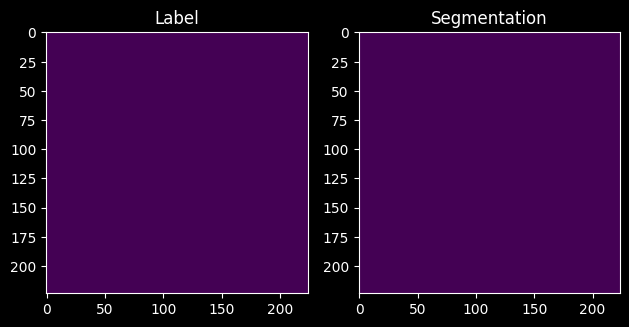

Batch 7


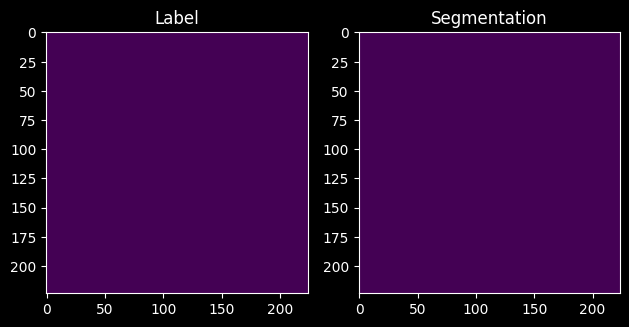

Batch 8


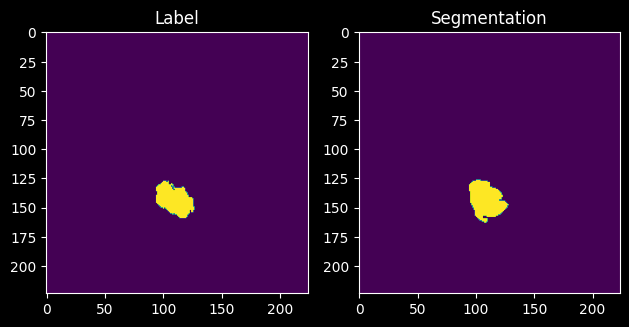

Batch 9


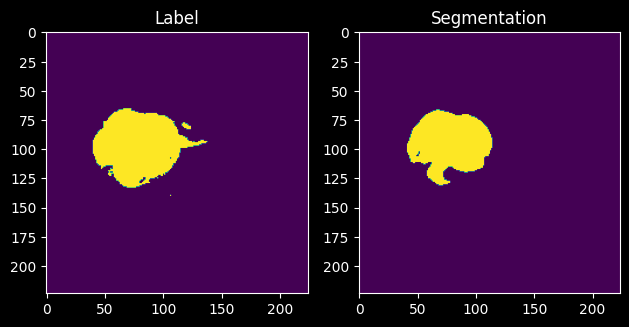

Batch 10


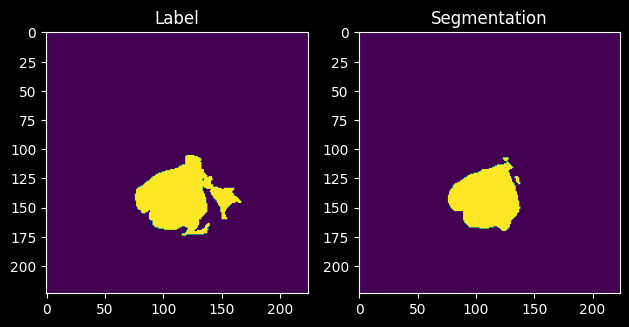

Total Avg_MIoU : 0.8051742487800382
Total Avg_Dice_Coef : 0.15425151207497362
Total Avg_Precision : 0.39324135444432534
Total Avg_Recall : 0.3354905036345437
 Total Avg_F1_Score : 0.3526245019876574


In [20]:
model.eval()
model.to('cpu')
count = 0

avg_miou = []
avg_dice_coef = []
avg_accuracy = []
avg_precision = []
avg_recall = []
avg_F1 = []

print("Print 10 test samples")
for sample in tqdm(test_loader):
    img, label = sample['image'], sample['label']
    
    image_batch, label_batch = img.to('cpu'), label.to('cpu')

    B, C, H, W = image_batch.shape
    image_batch = image_batch.expand(B, 3, H, W)
    
    outputs = model(image_batch)
    outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1, keepdim=True)

    avg_miou.append(calculate_miou(label_batch,outputs))
    avg_dice_coef.append(calculate_dice_loss(label_batch,outputs))
    avg_precision.append(calculate_precision(label_batch,outputs))
    avg_recall.append(calculate_recall(label_batch,outputs))
    avg_F1.append(calculate_f1_score(label_batch,outputs))
       
    
 
    if count < 10:
        print(f'Batch {count+1}')
        fig,axs = plt.subplots(1,2)
        axs[0].imshow(label[0].squeeze(0))
        axs[0].set_title('Label')
        axs[1].imshow(outputs[0].squeeze(0))
        axs[1].set_title('Segmentation')
        plt.tight_layout()
        plt.show()
    else:
        continue   
        
    count+= 1
    
print(f'Total Avg_MIoU : {sum(avg_miou)/len(test_loader)}\nTotal Avg_Dice_Coef : {sum(avg_dice_coef)/len(test_loader)}')
print(f"Total Avg_Precision : {sum(avg_precision)/len(test_loader)}")
print(f"Total Avg_Recall : {sum(avg_recall)/len(test_loader)}\n Total Avg_F1_Score : {sum(avg_F1)/len(test_loader)}")

# **Inference Class**

In [14]:
class predictor_h5(nn.Module):
    def __init__(self,model,output_size):
        super().__init__()
        self.model = model.eval()
        self.output_size = output_size
        
    def forward(self,x):
        img, label = x['image'][:], x['mask'][:]

        image, label = np.max(img,axis = -1), np.max(label,axis = -1)

        h, w = image.shape

        if h != self.output_size[0] or w != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / h, self.output_size[1] / w), order=3)  # why not 3?
            label = zoom(label, (self.output_size[0] / h, self.output_size[1] / w), order=0)

        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        label = torch.from_numpy(label.astype(np.float32)).long()


        image = image.expand(1,3,image.shape[1],image.shape[2])

        # forward path for image
        x = self.model(image)
        # give probability to each output class torch.argmax(torch.softmax(outputs, dim=1), dim=1, keepdim=True)
        x = torch.softmax(x,dim=1)
        # choose the class with the highest probability
        x = torch.argmax(x,dim=1,keepdim=True)
        
        return x

In [15]:
path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_100_slice_64.h5"
output_size = (224,224)

data = h5py.File(path)

In [16]:
img, label = data['image'][:], data['mask'][:]

image, label = np.max(img,axis = -1), np.max(label,axis = -1)

h, w = image.shape

if h != output_size[0] or w != output_size[1]:
    image = zoom(image, (output_size[0] / h, output_size[1] / w), order=3)  # why not 3?
    label = zoom(label, (output_size[0] / h, output_size[1] / w), order=0)

image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
label = torch.from_numpy(label.astype(np.float32)).long()


image = image.expand(1,3,image.shape[1],image.shape[2])

In [17]:
pred = predictor_h5(model,(224,224))
output = pred.forward(data)

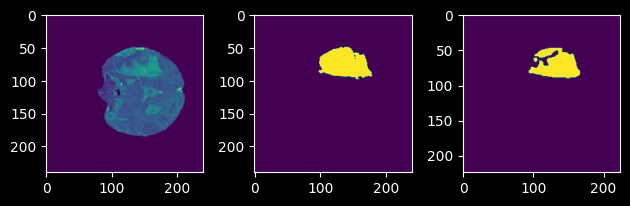

In [18]:
fig,axs = plt.subplots(1,3)
axs[0].imshow(np.max(data['image'][:],-1))
axs[1].imshow(np.max(data['mask'][:],-1))
axs[2].imshow(output[0].squeeze(0))
plt.tight_layout()
plt.show()

# **Classification**

In [15]:
csv=pd.read_csv("/kaggle/input/rsnabrats20212d/target.csv")

In [16]:
from keras.utils import Sequence
from sklearn.model_selection import train_test_split

class DataGenerator(Sequence):
    def __init__(self, csv, folders, selected_patients, batch_size=32, dim=(240, 240), shuffle=True):
        self.csv = csv
        self.folders = folders
        self.selected_patients = selected_patients
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.selected_patients))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.selected_patients) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_patients = [self.selected_patients[k] for k in indexes]
        X, y = self.__data_generation(batch_patients)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, batch_patients):
        # Allocate memory for the batch
        X = np.empty((self.batch_size * 4, *self.dim))  # Shape will be (batch_size * 4, 240, 240)
        y = np.empty((self.batch_size * 4), dtype=int)
        
        for i, patient in enumerate(batch_patients):
            if patient == 1650:  # Skip patient ID 01650
                continue
            
            patient_slices = self.csv[self.csv['BraTS21ID'] == patient]
            tumor_slices = patient_slices[patient_slices['tumor_slice'] == 1]
            non_tumor_slices = patient_slices[patient_slices['tumor_slice'] == 0]
            
            # Ensure we have enough slices for the selected criteria
            if len(tumor_slices) >= 3 and len(non_tumor_slices) >= 1:
                selected_slices = pd.concat([non_tumor_slices.sample(1), tumor_slices.sample(3)])
            else:
                selected_slices = patient_slices.sample(4, replace=True)  # Sample with replacement if needed
            
            for idx, row in enumerate(selected_slices.itertuples()):
                image_id = row.image_id
                tumor_slice = row.tumor_slice
                stacked_channels = []
                for modality in ['t1', 't2', 't1ce', 'flair']:
                    file_path = os.path.join(self.folders[modality], f'{modality}_BraTS2021_{patient:05d}_{image_id:03d}.png')
                    try:
                        channel = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
                        if channel is None:
                            # If image cannot be read, try the next modality
                            continue
                        stacked_channels.append(channel)
                        break  # Exit loop if image is successfully read
                    except (FileNotFoundError, OSError):
                        # Handle specific exceptions if needed
                        pass
                
                if len(stacked_channels) == 0:
                    # If no valid image is found, you can handle this case as per your requirement
                    # Here, we assign a blank image
                    stacked_channels.append(np.zeros(self.dim))
                
                # Stack channels along the last axis (axis=-1)
                stacked_image = np.stack(stacked_channels, axis=-1)
                
                # Take the maximum across channels to convert to single channel
                max_channel_image = np.max(stacked_image, axis=-1)
                
                # Ensure max_channel_image has the correct shape
                assert max_channel_image.shape == (*self.dim,), f"max_channel_image shape mismatch: {max_channel_image.shape}"
                
                X[i * 4 + idx] = max_channel_image
                y[i * 4 + idx] = tumor_slice  # Assign the label correctly
        
        # Reshape X to (batch_size * 4, 240, 240, 1) to match the model input shape
        X = np.expand_dims(X, axis=-1)
        
        return X, y


# Split selected patients into training and validation sets
unique_patients = csv['BraTS21ID'].unique()
selected_patients=unique_patients[:999]
test_patients = unique_patients[1000:1250]
train_patients, val_patients = train_test_split(selected_patients, test_size=0.2, random_state=42)

folders = {
    't1': '/kaggle/input/rsnabrats20212d/t1/',
    't2': '/kaggle/input/rsnabrats20212d/t2/',
    't1ce': '/kaggle/input/rsnabrats20212d/t1ce/',
    'flair': '/kaggle/input/rsnabrats20212d/flair/'
}

# Parameters
train_params = {
    'csv': csv,
    'folders': folders,
    'selected_patients': train_patients,
    'batch_size': 8,  # Adjust based on available memory and batch size requirements
    'shuffle': True
}
# Parameters
valid_params = {
    'csv': csv,
    'folders': folders,
    'selected_patients': val_patients,
    'batch_size': 8,  # Adjust based on available memory and batch size requirements
    'shuffle': False
}
# Parameters
test_params = {
    'csv': csv,
    'folders': folders,
    'selected_patients': test_patients,
    'batch_size': 8,  # Adjust based on available memory and batch size requirements
    'shuffle': False
}

# Generators
training_generator = DataGenerator(**train_params)
valid_generator = DataGenerator(**valid_params)
test_generator = DataGenerator(**test_params)

In [17]:
# Example usage of the generator (printing the first batch)
for epoch in range(1):  # Run for 1 epoch as an example
    for X_batch, y_batch in training_generator:
        print(f"X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")
        break

X_batch shape: (32, 240, 240, 1), y_batch shape: (32,)


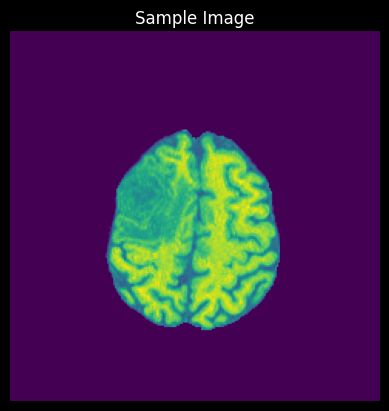

In [18]:
# Assuming X_batch is a numpy array and X_batch[0] is the first image
image = X_batch[7]

# Squeeze the last dimension if it's a single channel image
image = np.squeeze(image)

# Plot the image
plt.imshow(image)
plt.title('Sample Image')
plt.axis('off')  # Hide the axis
plt.show()

In [19]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(240, 240, 3))


input_shape = (240,240,1)
# Modify the model to accept grayscale images (1 channel)
input_tensor = Input(shape=input_shape)
x = Concatenate()([input_tensor, input_tensor, input_tensor])  # Convert 1 channel to 3 channels
x = base_model(x, training=False)

# Add new layers
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Use a single neuron with sigmoid for binary classification

# Create the model
model = Model(inputs=input_tensor, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Train the model
epochs = 10
# history=model2.fit(training_generator, epochs=epochs)

# Train the model
history = model.fit(training_generator, epochs=epochs, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
 2/99 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5156 - loss: 1.3169  

I0000 00:00:1719172053.184985     250 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 363ms/step - accuracy: 0.7090 - loss: 0.8239 - learning_rate: 0.0010
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7803 - loss: 0.4689 - learning_rate: 0.0010
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 348ms/step - accuracy: 0.7757 - loss: 0.4743 - learning_rate: 0.0010
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 33s 311ms/step - accuracy: 0.7634 - loss: 0.4813 - learning_rate: 0.0010
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 32s 305ms/step - accuracy: 0.7748 - loss: 0.4745 - learning_rate: 0.0010
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 287ms/step - accuracy: 0.7901 - loss: 0.4502 - learning_rate: 0.0010
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 273ms/step - accuracy: 0.7791 - loss: 0.4511 - learning_rate: 0.0010
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 282ms/step - accuracy: 0.7928 - loss: 0.4381 - learning_rate: 0.0010
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - accuracy: 0.7918 - loss: 0.4371 - learning_rate: 0.0010
Epoch 10/10


In [22]:
# Save the model
model_save_path = '/kaggle/working/Classification.h5'
model.save(model_save_path)

print("Model saved.")

Model saved.


In [23]:
# To load the model and recompile it
model2 = load_model(model_save_path)
print("Model loaded.")
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model loaded.


# **Evaluation**

In [24]:
y_true = []
y_pred = []

for epoch in range(1):
    for X_batch, y_batch in test_generator:
        # Generate predictions for the current batch
        batch_pred = model2.predict(X_batch)
        # Append true labels
        y_true.extend(y_batch)
        # Binarize predictions (assuming binary classification)
        batch_pred = (batch_pred > 0.5).astype(int)
        y_pred.extend(batch_pred)
        break

# Convert lists to numpy arrays for further processing
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


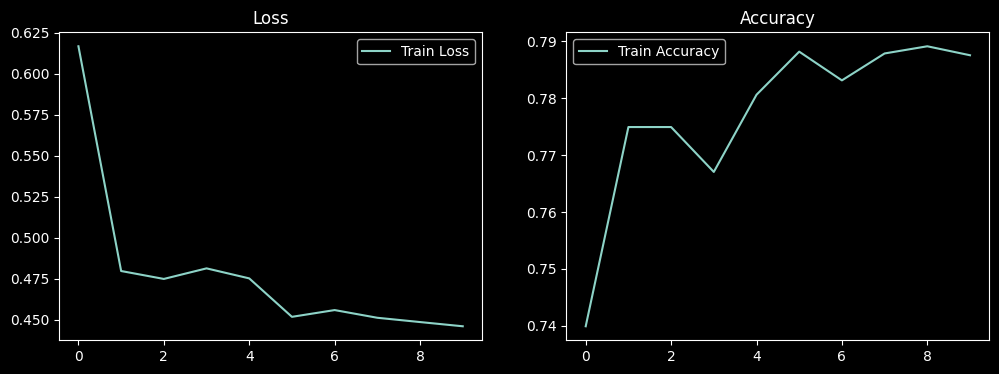

In [25]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

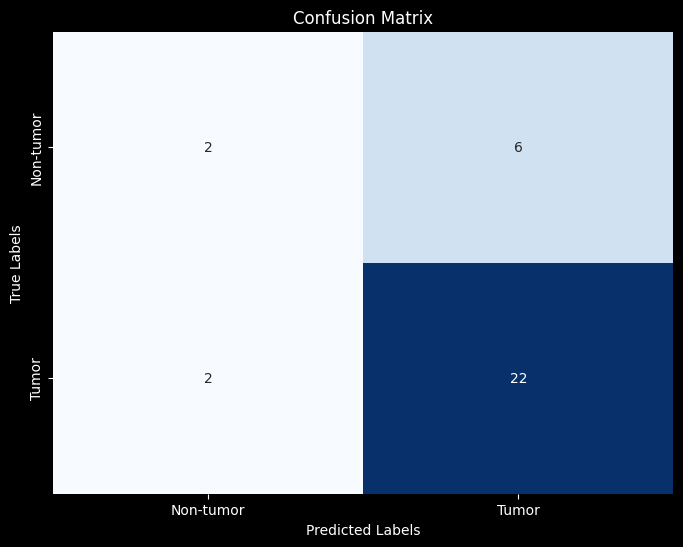

In [26]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-tumor', 'Tumor'], yticklabels=['Non-tumor', 'Tumor'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Generate the classification report
report = classification_report(y_true, y_pred, target_names=['Non-tumor', 'Tumor'])
print(report)

              precision    recall  f1-score   support

   Non-tumor       0.50      0.25      0.33         8
       Tumor       0.79      0.92      0.85        24

    accuracy                           0.75        32
   macro avg       0.64      0.58      0.59        32
weighted avg       0.71      0.75      0.72        32



# **Image Classification**

In [29]:
path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_100_slice_64.h5"
output_size = (224,224)

data = h5py.File(path)

In [30]:
image_data = data['image'][:] # Adjust indexing as per your data structure

# Compute the maximum value across the last axis (channel axis)
max_image = np.max(image_data, axis=-1)

# Ensure the shape is correct after the operation
print(f"Shape of max_image: {max_image.shape}")

Shape of max_image: (240, 240)


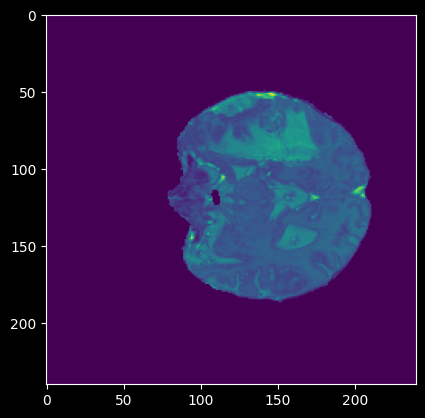

In [31]:
plt.imshow(max_image)

In [32]:
# Add batch dimension and channel dimension
max_image = np.expand_dims(max_image, axis=0) # Add batch dimension
max_image = np.expand_dims(max_image, axis=-1) # Add channel dimension for grayscale

# Print the shape after preprocessing
print(f"Shape of the first image after preprocessing: {max_image.shape}")

Shape of the first image after preprocessing: (1, 240, 240, 1)


In [34]:
# Now predict using the model
prediction = model.predict(max_image)

# Print the predictions or further process them as needed
print("Glioma Percentage : ",prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Glioma Percentage :  0.6419026


# **Segmented Output Classification**

In [35]:
# Assuming output[0] is your image data with shape (224, 224)
segment = np.array(output[0].squeeze(0))  # Adjust indexing as per your data structure

# Resize the image to (240, 240)
segment = resize(segment, (240, 240))

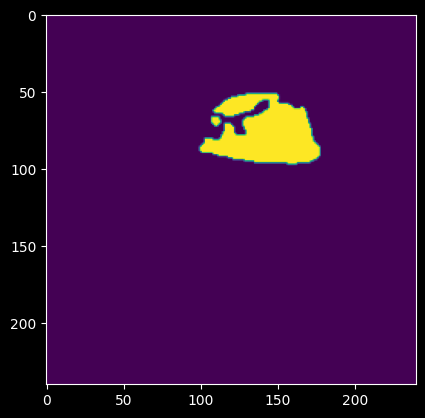

In [36]:
plt.imshow(segment)

In [37]:
# Add batch and channel dimensions
segment = np.expand_dims(segment, axis=0)  # Add batch dimension
segment = np.expand_dims(segment, axis=-1)  # Add channel dimension for grayscale

# Print the shape after preprocessing
print(f"Shape of the first image after preprocessing: {segment.shape}")  # Shape should be (1, 240, 240, 1)

Shape of the first image after preprocessing: (1, 240, 240, 1)


In [39]:
# Now predict using the model
prediction = model.predict(segment)

# Print the predictions or further process them as needed
print(prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
0.04149588


In [ ]:
cd /kaggle/working/BEFUnet_Brats2020

In [49]:
from huggingface_hub import login
login()

In [50]:
from huggingface_hub import HfApi

api = HfApi()

In [51]:
api.upload_file(
    path_or_fileobj="/kaggle/working/Classification.h5",
    path_in_repo="model/Classification.h5",
    repo_id="Unknown6197/res_classification",
    repo_type="model",
)

Classification.h5:   0%|          | 0.00/120M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Unknown6197/res_classification/commit/72d72072e638c660bf013e92e91e63f67d845cfa', commit_message='Upload model/Classification.h5 with huggingface_hub', commit_description='', oid='72d72072e638c660bf013e92e91e63f67d845cfa', pr_url=None, pr_revision=None, pr_num=None)